### Iterative hard thresholding with unit step size

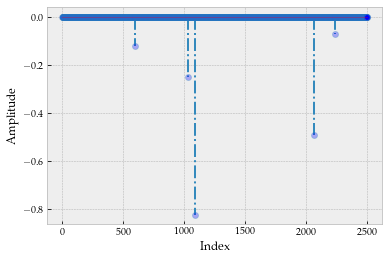

17.744732362727305


In [34]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import brewer

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import random
from numpy import linalg as la

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

p = 2500  # Ambient dimension
# Number of samples
# n = 300
# n = 350
n = 2000  # testing large n - mess with this more
k = 5   # Sparsity level

# Generate a p-dimensional zero vector
x_star = np.zeros(p)
# Randomly sample k indices in the range [1:p]
x_star_ind = random.sample(range(p),  k)
# Set x_star_ind with k random elements from Gaussian distribution
x_star[x_star_ind] = np.random.randn(k)
# Normalize
x_star = (1 / la.norm(x_star, 2)) * x_star

# Plot
plt.style.use('bmh')
xs = range(p)
markerline, stemlines, baseline = plt.stem(xs, x_star, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

# Generate sensing matrix
Phi = (1 / math.sqrt(n)) * np.random.randn(n, p)

print(la.cond(Phi))

# Compute largest singular value of A
U,S,V = la.svd(Phi)
L = max(S)**2

# Observation model
y = Phi @ x_star

In [2]:
# Hard thresholding function
def hardThreshold(x, k):
    p = x.shape[0]
    t = np.sort(np.abs(x))[::-1]    
    threshold = t[k-1]
    j = (np.abs(x) < threshold)
    x[j] = 0
    return x

# Returns the value of the objecive function
def f(y, A, x):
    return 0.5 * math.pow(la.norm(y - Phi @ x, 2), 2)

def IHT(y, A, k, eta, iters, epsilon, verbose, x_star):
    # Length of original signal
    p = A.shape[1]
    # Length of measurement vector
    n = A.shape[0]
    # Initial estimate
    x_new = np.zeros(p)    
    # Transpose of A
    At = np.transpose(A)

    # Initialize
    x_new = np.zeros(p)           # The algorithm starts at x = 0

    PhiT = np.transpose(Phi)
    
    x_list, f_list = [1], [f(y, Phi, x_new)]

    for i in range(iters):
        x_old = x_new
    
        # Compute gradient
        grad = -PhiT @ (y - Phi @ x_new)
    
        # Perform gradient step
        x_temp = x_old - eta * grad    
    
        # Perform hard thresholding step
        x_new = hardThreshold(x_temp, k)
    
        if (la.norm(x_new - x_old, 2) / la.norm(x_new, 2)) < epsilon:
            break
                
        # Keep track of solutions and objective values
        x_list.append(la.norm(x_new - x_star, 2))
        f_list.append(f(y, Phi, x_new))
        
        if verbose:
            print("iter# = "+ str(i) + ", ||x_new - x_old||_2 = " + str(la.norm(x_new - x_old, 2)))
    
    print("Number of steps:", len(f_list))
    return x_new, x_list, f_list
    

Number of steps: 30


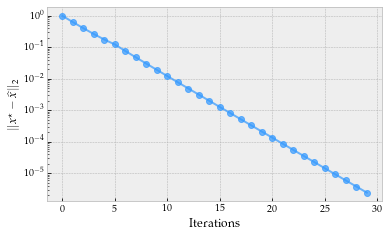

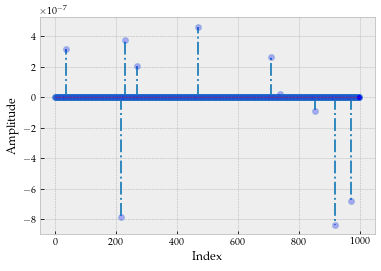

In [3]:
# Run algorithm (IHT)
epsilon = 1e-6                # Precision parameter
iters = 1000
eta = 0.4
# eta = 1/L

x_IHT, x_list, f_list = IHT(y, Phi, k, eta, iters, epsilon, False, x_star)


# Plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

xs = range(len(x_list))
plt.plot(xs, x_list, '-o', color = '#3399FF', linewidth = 2, alpha = 0.7)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r"$\|x^\star - \widehat{x}\|_2$")

# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)
plt.show()

plt.style.use('bmh')
xs = range(p)
markerline, stemlines, baseline = plt.stem(xs, x_IHT - x_star, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

In [41]:
def check_sparsity(arr, cutoff):
    sparsity_counter = 0
    for val in arr:
        if abs(val) > cutoff:
            sparsity_counter += 1
            
    return sparsity_counter

def threshold(arr, sparsity):
    if sparsity >= arr.size:
        return arr
    
    new_arr = np.copy(arr)
    sorted_arr = np.sort(np.absolute(arr))
    cutoff = sorted_arr[arr.size - sparsity]
    
    for i in range(arr.size):
        if abs(arr[i]) < cutoff:
            new_arr[i] = 0
            
    return new_arr

11.570765324361025


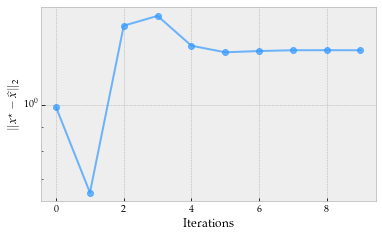

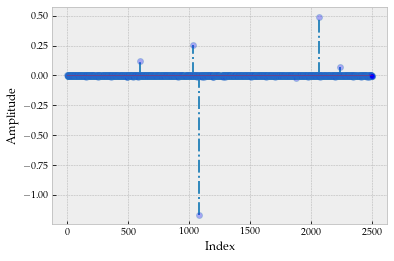

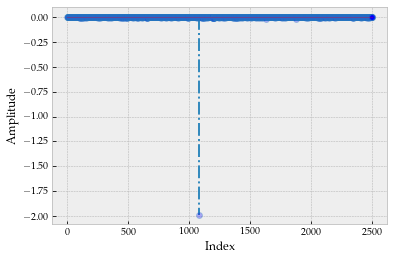

sparsity: 2479


In [44]:
# Hoff
# not a gradient descent algorithm
# performs quite poorly
# notably, each iteration takes quite a long time (this was mentioned in the paper), so for this algorithm
# to be effective, it must converge in very few iterations
def HPP(y, X, lambda_param, init_v, iters, epsilon, verbose, beta_star):
    # Length of original signal
    p = X.shape[1]
    # Length of measurement vector
    n = X.shape[0]
    
    # Helper vars
    Xt = np.transpose(X)
    Q = Xt @ X
    l = Xt @ y
    mod_I = np.identity(p) * (lambda_param / 2)
    
    # Initialize
    v = init_v
    
    beta_list, f_list = [], []
    
    # convergence criteria not implemented yet
    for i in range(iters):
        vvt = v @ np.transpose(v)
        u = la.inv(np.multiply(Q, vvt) + mod_I) @ np.multiply(l, v)
        
        uut = u @ np.transpose(u)
        v = la.inv(np.multiply(Q, uut) + mod_I) @ np.multiply(l, u)
        
        beta = np.multiply(u, v)
        beta_list.append(la.norm(beta_star - beta, 2))
        f_list.append(f(y, X, beta))
        
        if verbose:
            print(beta_list[-1], f_list[-1])
            
    return beta, beta_list, f_list
        
lambda_param = 0.5
alpha = 0.00001
# init_v = la.lstsq(Phi, y)[0]
init_v = np.random.uniform(alpha * -1, alpha, p)
print(la.norm(Phi @ init_v - y, 2))
iters = 10 # fewer iterations for this algorithm
beta_HPP, beta_list, f_list = HPP(y, Phi, lambda_param, init_v, iters, epsilon, False, x_star)

# Plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

bs = range(len(beta_list))
plt.plot(bs, beta_list, '-o', color = '#3399FF', linewidth = 2, alpha = 0.7)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r"$\|x^\star - \widehat{x}\|_2$")

# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)
plt.show()

plt.style.use('bmh')
bs = range(p)
markerline, stemlines, baseline = plt.stem(bs, beta_HPP - x_star, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

plt.style.use('bmh')
bs = range(p)
markerline, stemlines, baseline = plt.stem(bs, beta_HPP, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

# print(beta_HPP)
print('sparsity:', check_sparsity(beta_HPP, 0.0000001))

number of iterations: 914


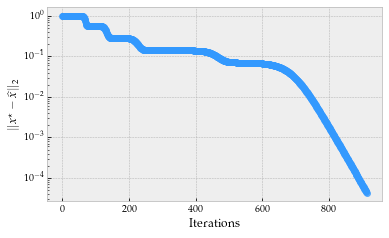

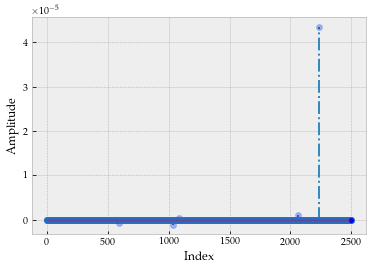

original sparsity: 0
original error: 4.356027758865595e-05
original objective function final val: 9.680246218470249e-10


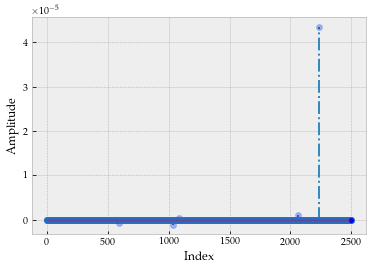

threshold sparsity: 0
threshold error: 4.3560276986020325e-05
threshold objective function val: 9.681058531036054e-10


In [35]:
# hadamard gradient descent (Zhao)
# with large eta, objective function is minimized, but experimental beta far from actual beta
def HGD(y, X, eta, iters, alpha, epsilon, verbose, beta_star):
    # Length of original signal
    p = X.shape[1]
    # Length of measurement vector
    n = X.shape[0]
    
    # Helper vars
    Xt = np.transpose(X)
    
    # Initialize
    u_new = np.random.uniform(alpha * -1, alpha, p)
#     u_new = (1 / la.norm(u_new, 2)) * u_new
    v_new = np.random.uniform(alpha * -1, alpha, p)
#     v_new = (1 / la.norm(v_new, 2)) * v_new
    
    beta_new = np.multiply(u_new, v_new)
    beta_list = [la.norm(beta_new - beta_star, 2)]
    f_list = [f(y, X, beta_new)]
    
    # gradient descent
    for i in range(iters):
        u_old = u_new
        v_old = v_new
        beta_old = np.multiply(u_old, v_old)
        
        u_new = u_old - (eta * np.multiply(v_old, (Xt @ (X @ beta_old - y))))
        v_new = v_old - (eta * np.multiply(u_old, (Xt @ (X @ beta_old - y))))
        
        beta_new = np.multiply(u_new, v_new)
        
        beta_list.append(la.norm(beta_new - beta_star, 2))
        f_list.append(f(y, X, beta_new))
        
        if verbose:
            print(beta_list[-1], f_list[-1])
        
        # never reaches this convergence criteria
        if la.norm(X @ beta_new - y, 2) / (n ** 0.5) <= epsilon:
            print("number of iterations:", i)
            break
    
    return beta_new, beta_list, f_list

iters = 1000
alpha = 0.00001
# eta = 1  # much larger eta (step size) performs better for some reason, and small eta does not converge quickly
eta = 1/L  # XtX is hessian --> compute SVD (L = max singular value of XtX, squared)
beta_HGD, beta_list, f_list = HGD(y, Phi, eta, iters, alpha, epsilon, False, x_star)

# Plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

bs = range(len(beta_list))
plt.plot(bs, beta_list, '-o', color = '#3399FF', linewidth = 2, alpha = 0.7)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r"$\|x^\star - \widehat{x}\|_2$")

# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)
plt.show()

plt.style.use('bmh')
bs = range(p)
markerline, stemlines, baseline = plt.stem(bs, beta_HGD - x_star, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

print('original sparsity:', check_sparsity(beta_HGD, 0.0000001))
print('original error:', beta_list[-1])
print('original objective function final val:', f_list[-1])
threshold_beta = threshold(beta_HGD, k)

plt.style.use('bmh')
bs = range(p)
markerline, stemlines, baseline = plt.stem(bs, threshold_beta - x_star, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

print('threshold sparsity:', check_sparsity(threshold_beta, 0))
print('threshold error:', la.norm(threshold_beta - x_star, 2))
print('threshold objective function val:', f(y, Phi, threshold_beta))

number of iterations: 1000


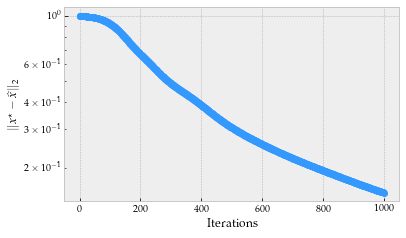

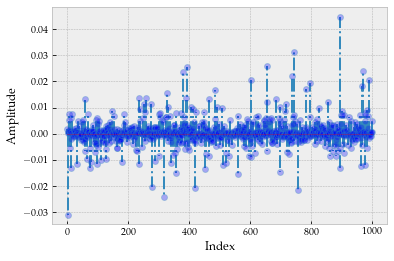

In [6]:
# hadamard gradient descent with early stopping (Zhao)
def HGD_early_stopping(y, X, y_prime, X_prime, eta, iters, epsilon, verbose, beta_star):
    # Length of original signal
    p = X.shape[1]
    # Length of measurement vector
    n = X.shape[0]
    
    # Helper vars
    Xt = np.transpose(X)
    
    # Initialize
    u_new = np.random.rand(p) - 0.5
    u_new = (1 / la.norm(u_new, 2)) * u_new
    v_new = np.random.rand(p) - 0.5
    v_new = (1 / la.norm(v_new, 2)) * v_new
    
    beta_new = np.multiply(u_new, v_new)
    beta_list = [la.norm(beta_new - beta_star, 2)]
    f_list = [f(y, X, beta_new)]
    betas = [beta_new]
    
    # gradient descent
    for i in range(iters):
        u_old = u_new
        v_old = v_new
        beta_old = np.multiply(u_old, v_old)
        
        u_new = u_old - (eta * np.multiply(v_old, (1 / n) * (Xt @ (X @ beta_old - y))))
        v_new = v_old - (eta * np.multiply(u_old, (1 / n) * (Xt @ (X @ beta_old - y))))
        
        beta_new = np.multiply(u_new, v_new)
        
        # this kind of early stopping causes the algorithm to stop after the first iteration
        # not sure why this is a > in the first place (seems more intuitive to be <)
#         if la.norm(X_prime @ beta_old - y_prime, 2) > la.norm(X_prime @ beta_new - y_prime, 2):
#             print("number of iterations:", i)
#             return beta_old, beta_list, f_list
        
        beta_list.append(la.norm(beta_new - beta_star, 2))
        f_list.append(f(y, X, beta_new))
        betas.append(beta_new)
        
        if verbose:
            print(beta_list[-1], f_list[-1])
    
    # other method of early stopping: return beta that minimizes f
    # does not actually stop early though: goes through all iterations because f gets incrementally smaller
    min_index = f_list.index(min(f_list))
    print("number of iterations:", min_index)
    return betas[min_index], beta_list, f_list

# Generate validation data
Phi_prime = (1 / math.sqrt(n)) * np.random.randn(n, p)
y_prime = Phi_prime @ x_star

iters = 1000
eta = 100
beta_HGD, beta_list, f_list = HGD_early_stopping(y, Phi, y_prime, Phi_prime, eta, iters, epsilon, False, x_star)

# Plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

bs = range(len(beta_list))
plt.plot(bs, beta_list, '-o', color = '#3399FF', linewidth = 2, alpha = 0.7)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r"$\|x^\star - \widehat{x}\|_2$")

# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)
plt.show()

plt.style.use('bmh')
bs = range(p)
markerline, stemlines, baseline = plt.stem(bs, beta_HGD - x_star, '-.')
plt.setp(markerline, 'alpha', 0.3, 'ms', 6)
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(baseline, 'color', 'r', 'linewidth', 1, 'alpha', 0.3)
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()